# Network Traffic Forecasting (using time series data)

In telco, accurate forecast of KPIs (e.g. network traffic, utilizations, user experience, etc.) for communication networks ( 2G/3G/4G/5G/wired) can help predict network failures, allocate resource, or save energy. 

In this notebook, we demonstrate a reference use case where we use the network traffic KPI(s) in the past to predict traffic KPI(s) in the future. We demostrate how to do **multivariate multistep forecasting** using Project Chronos.

For demonstration, we use the publicly available network traffic data repository maintained by the [WIDE project](http://mawi.wide.ad.jp/mawi/) and in particular, the network traffic traces aggregated every 2 hours (i.e. AverageRate in Mbps/Gbps and Total Bytes) in year 2018 and 2019 at the transit link of WIDE to the upstream ISP ([dataset link](http://mawi.wide.ad.jp/~agurim/dataset/)). 

## Helper functions

This section defines some helper functions to be used in the following procedures. You can refer to it later when they're used.

In [1]:
def plot_predict_actual_values(date, y_pred, y_test, ylabel):
    """
    plot the predicted values and actual values (for the test data)
    """
    fig, axs = plt.subplots(figsize=(12,5))

    axs.plot(date, y_pred, color='red', label='predicted values')
    axs.plot(date, y_test, color='blue', label='actual values')
    axs.set_title('the predicted values and actual values (for the test data)')

    plt.xlabel('test datetime')
    plt.ylabel(ylabel)
    plt.legend(loc='upper left')
    plt.show()

## Data pre-processing

In [2]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from zoo.chronos.data.repo_dataset import get_public_dataset
%matplotlib inline

get public dataset will download to the local according to the selected data name, complete the data cleaning and preprocessing, and then return the three tsdata after flipping, the Belgium default 0.8:0.1:0.1.

In [3]:
tsdata_train,_,tsdata_test = get_public_dataset(name='network_traffic',path='~/.chronos/dataset')
df = pd.read_csv('~/.chronos/dataset/network_traffic/network_traffic_data.csv')
# Unify AvgRate value
df['AvgRate'] = df.AvgRate.apply(lambda x:float(x[:-4]) if x.endswith("Mbps") else float(x[:-4])*1000)

In [4]:
df.head()

,StartTime,EndTime,AvgRate,total
0,2018/01/01 00:00:00,2018/01/01 02:00:00,306.23,275605455598
1,2018/01/01 02:00:00,2018/01/01 04:00:00,285.03,256527692256
2,2018/01/01 04:00:00,2018/01/01 06:00:00,247.39,222652190823
3,2018/01/01 06:00:00,2018/01/01 08:00:00,211.55,190396029658
4,2018/01/01 08:00:00,2018/01/01 10:00:00,234.82,211340468977


Plot the data to see how the KPI's look like

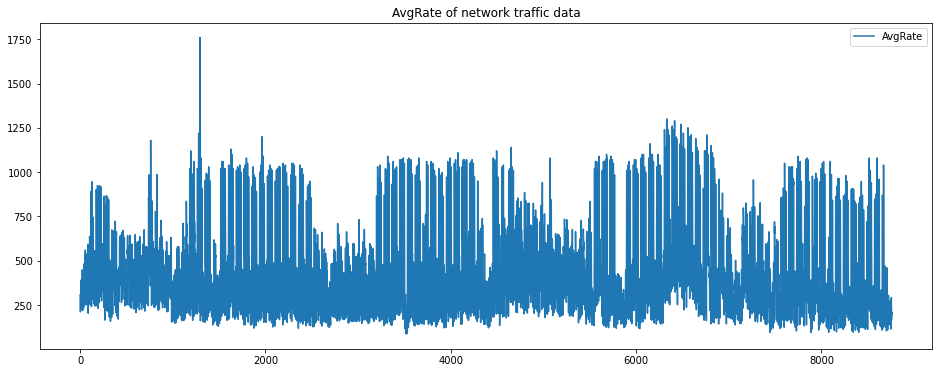

In [5]:
ax = df.plot(y='AvgRate', figsize=(16,6), title="AvgRate of network traffic data")

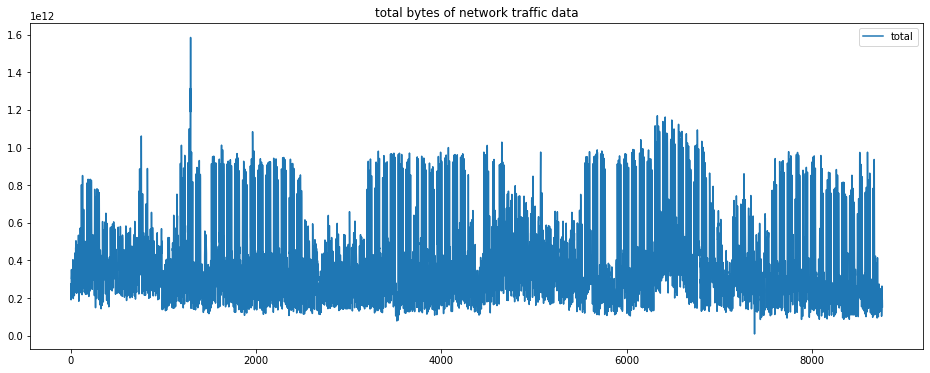

In [6]:
ax = df.plot(y='total', figsize=(16,6), title='total bytes of network traffic data')

## Feature Engineering & Data Preperation

For feature engineering, we use year, month, week, day of week and hour as features in addition to the target KPI values.

For data preperation, we impute the data to handle missing data and scale the data. At last we generate the sample in numpy ndarray for Forecaster to use.

In [7]:
from sklearn.preprocessing import StandardScaler

# we look back one week data which is of the frequency of 2h.
look_back = 84
# specify the number of steps to be predicted，one day is selected by default.
horizon = 12

standard_scaler = StandardScaler()

for tsdata in [tsdata_train, tsdata_test]:
    tsdata.gen_dt_feature()\
          .impute(mode="last")\
          .scale(standard_scaler, fit=(tsdata is tsdata_train))\
          .roll(lookback=look_back, horizon=horizon)

x_train, y_train = tsdata_train.to_numpy()
x_test, y_test = tsdata_test.to_numpy()
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6913, 84, 12), (6913, 12, 2), (781, 84, 12), (781, 12, 2))

# Time series forecasting 

We demonstrate how to use chronos TCNForecaster for multi-variate and multi-step forecasting. For more details, you can refer to TCNForecaster document [here](https://analytics-zoo.github.io/master/#Chronos/API/TCNForecaster/).
First, we initialize a forecaster.
* `num_channels`: The filter numbers of the convolutional layers. It can be a list.
* `kernel_size`: Convolutional layer filter height.

In [8]:
from zoo.chronos.model.forecast.tcn_forecaster import TCNForecaster
forecaster = TCNForecaster(past_seq_len = look_back,
                           future_seq_len = horizon,
                           input_feature_num = x_train.shape[-1],
                           output_feature_num = 2, # "AvgRate" and "total"
                           num_channels = [30] * 7, 
                           kernel_size = 4, 
                           dropout = 0.1, 
                           lr = 0.001)

You can use this method to print the parameter list.

In [9]:
forecaster.data_config, forecaster.config

({'past_seq_len': 84,
  'future_seq_len': 12,
  'input_feature_num': 12,
  'output_feature_num': 2},
 {'lr': 0.001,
  'loss': 'mse',
  'num_channels': [30, 30, 30, 30, 30, 30, 30],
  'kernel_size': 4,
  'optim': 'Adam',
  'dropout': 0.1})

In [10]:
%%time
forecaster.fit(x=x_train, y=y_train, epochs=20, batch_size=256, metric="mse")

Loss: 0.03048863261938095: 100%|██████████| 28/28 [00:03<00:00,  7.69it/s]


CPU times: user 6min 47s, sys: 3.21 s, total: 6min 50s
Wall time: 1min 9s


{'mse': 0.1384440981692325}

After training is finished. You can use the forecaster to do prediction and evaluation.

In [11]:
# make prediction
y_pred = forecaster.predict(x_test)

Since we have used standard scaler to scale the input data (including the target values), we need to inverse the scaling on the predicted values too. 

In [12]:
y_pred_unscale = tsdata_test.unscale_numpy(y_pred)
y_test_unscale = tsdata_test.unscale_numpy(y_test)

Calculate mean square error and the symetric mean absolute percentage error.

In [13]:
# evaluate with mse, smape
from zoo.automl.common.metrics import Evaluator
avgrate_mse = Evaluator.evaluate("mse", y_test_unscale[:, :, 0], y_pred_unscale[:, :, 0], multioutput='uniform_average')
avgrate_smape = Evaluator.evaluate("smape", y_test_unscale[:, :, 0], y_pred_unscale[:, :, 0], multioutput='uniform_average')
total_mse = Evaluator.evaluate("mse", y_test_unscale[:, :, 1], y_pred_unscale[:, :, 1], multioutput='uniform_average')
total_smape = Evaluator.evaluate("smape", y_test_unscale[:, :, 1], y_pred_unscale[:, :, 1], multioutput='uniform_average')
print(f"Evaluation result for AvgRate: mean squared error is {'%.2f' % avgrate_mse}, sMAPE is {'%.2f' % avgrate_smape}")
print(f"Evaluation result for total: mean squared error is {'%.2f' % total_mse}, sMAPE is {'%.2f' % total_smape}")

Evaluation result for AvgRate: mean squared error is 13001.42, sMAPE is 12.61
Evaluation result for total: mean squared error is 10559166208169318809600.00, sMAPE is 12.64


## Visualization

Plot actual and prediction values for `AvgRate` KPI

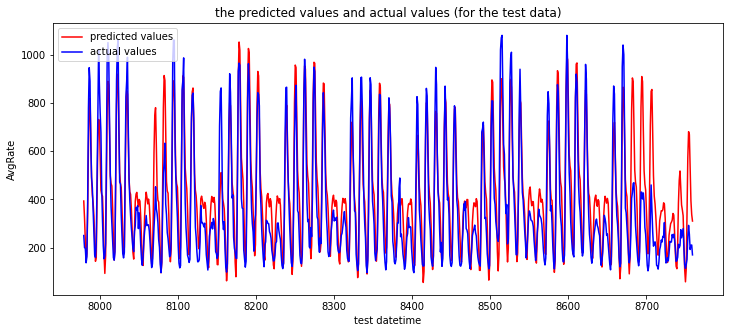

In [14]:
test_date=df[-y_pred_unscale.shape[0]:].index
# You can choose the number of painting steps by specifying the step by yourself.
step = -1 # the last step
target_name = "AvgRate"
target_index = 0
plot_predict_actual_values(date=test_date, y_pred=y_pred_unscale[:, step, target_index], y_test=y_test_unscale[:, step, target_index], ylabel=target_name)

Plot actual and prediction values for `total bytes` KPI

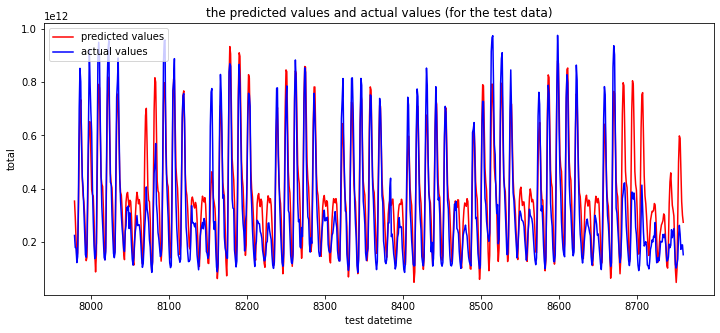

In [15]:
target_name = "total"
target_index = 1
plot_predict_actual_values(date=test_date, y_pred=y_pred_unscale[:, step, target_index], y_test=y_test_unscale[:, step, target_index], ylabel=target_name)